# Prerequisites

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta
import numpy as np

is_on_colab = False

In [2]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"

Running on Local


In [2]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(1127)#Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone'
Hypers.Config.data_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\data'
Hypers.Config.model_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\model'
Hypers.Config.log_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\log'


In [3]:
suffix = "RetInd"
window_size = 8

In [4]:
import CompustatExtractor
importlib.reload(CompustatExtractor)
from CompustatExtractor import CompustatExtractor

dataset_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}.pkl")
dataset_noCPI_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}_noCPI.pkl")

features = CompustatExtractor.process_compustat_features(
	os.path.join(Hypers.Config.data_path, "WRDS", f"features_{suffix}.csv"),
	save=False,
	filestem=f"features_{suffix}",
	add_cpi=True
)

concatenate_features = CompustatExtractor.concatenate_features(features, k=window_size)

ratings = CompustatExtractor.process_compustat_ratings(
	os.path.join(Hypers.Config.data_path, "WRDS", f"ratings_{suffix}.csv"),
	save=False,
	filestem=f"ratings_{suffix}"
)

merged_dict = CompustatExtractor.merge_input_output_dicts(
	concatenate_features,
	ratings,
	save=True,
	filestem=f"dataset_{suffix}_{window_size}"
)


input_dict: 924
output_dict: 392
merged_dict: 342


# Conv1d

In [9]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel2
importlib.reload(ConvModel2)

model_type = "Conv"

In [5]:
def apply_scaler(data_dict, scaler):
    scaled_dict = {}
    for company, data in data_dict.items():
        scaled_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            features = scaler.transform(features.reshape(1, -1)).reshape(features.shape)
            scaled_dict[company][period] = (features, label, label_normalized)
    return scaled_dict

In [6]:
from sklearn.preprocessing import PowerTransformer

def apply_power_transformation(data_dict):
    transformer = PowerTransformer(method='yeo-johnson')
    all_features = []
    for company, data in data_dict.items():
        for period, (features, label, label_normalized) in data.items():
            features = np.clip(features, a_min=-1e6, a_max=1e6)
            all_features.append(features.reshape(1, -1))
    
    transformer.fit(np.vstack(all_features))
    
    transformed_dict = {}
    for company, data in data_dict.items():
        transformed_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            transformed_features = transformer.transform(features.reshape(1, -1)).reshape(features.shape)
            transformed_dict[company][period] = (transformed_features, label, label_normalized)
    
    return transformed_dict

#### Kernel size = 5

In [7]:
kernel_size = 5

In [11]:
from sklearn.preprocessing import StandardScaler

results_over_threshold = []
threshold = 0
best_history = []
best_acc = 0

preprocess = {"standardize": True, "power_transformation": True} 
merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}_{window_size}.pkl"))
    
if preprocess["standardize"]:
    scaler = StandardScaler()
    all_features = []
    for company, data in merged_dict.items():
        for period, (features, label, label_normalized) in data.items():
            all_features.append(features.reshape(1, -1))
    scaler.fit(np.vstack(all_features))
    
    merged_dict = apply_scaler(merged_dict, scaler)

if preprocess["power_transformation"]:        
    merged_dict = apply_power_transformation(merged_dict)

train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)

architecture = {"dropout": True, "batch_norm": True, "num_conv_layers": 2}
reg_param = 1e-4
activation_fn = nn.SiLU
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
model = ConvModel2.ConvModel(feature_size=input_size,
                            num_conv_layers=architecture["num_conv_layers"],
                            dropout=architecture["dropout"],
                            batch_norm=architecture["batch_norm"],
                            activation_fn=activation_fn,
                            kernel_size=kernel_size)

train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)

train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)

criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer.Trainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            device=device,
                            train_loader=train_loader,
                            valid_loader=valid_loader,
                            model_type=model_type)

train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
print(f"Combination: Preprocess={preprocess}, Architecture={architecture}, Reg Param={reg_param}, Activation={activation_fn.__name__}\n-> Valid Accuracy: {valid_accuracy[-1]}")

if valid_accuracy[-1] > threshold:
    results_over_threshold.append({
        "preprocess": preprocess,
        "architecture": architecture,
        "reg_param": reg_param,
        "activation_fn": activation_fn.__name__,
        "valid_accuracy": valid_accuracy[-1]
    })
if best_acc < valid_accuracy[-1]:
    best_history = [train_loss, train_accuracy, valid_loss, valid_accuracy]

# utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


Calculated Fully connected input size: 576


Vaild Epoch 99: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it, Loss: 0.005]

Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5419029615626969


In [14]:
extended_feature_names = [f"{name}{i}" for i in range(1, 9) for name in Hypers.feature_list + ["CPI"]]

c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: SiLU
  warnings.warn(f'unrecognized nn.Module: {module_type}')


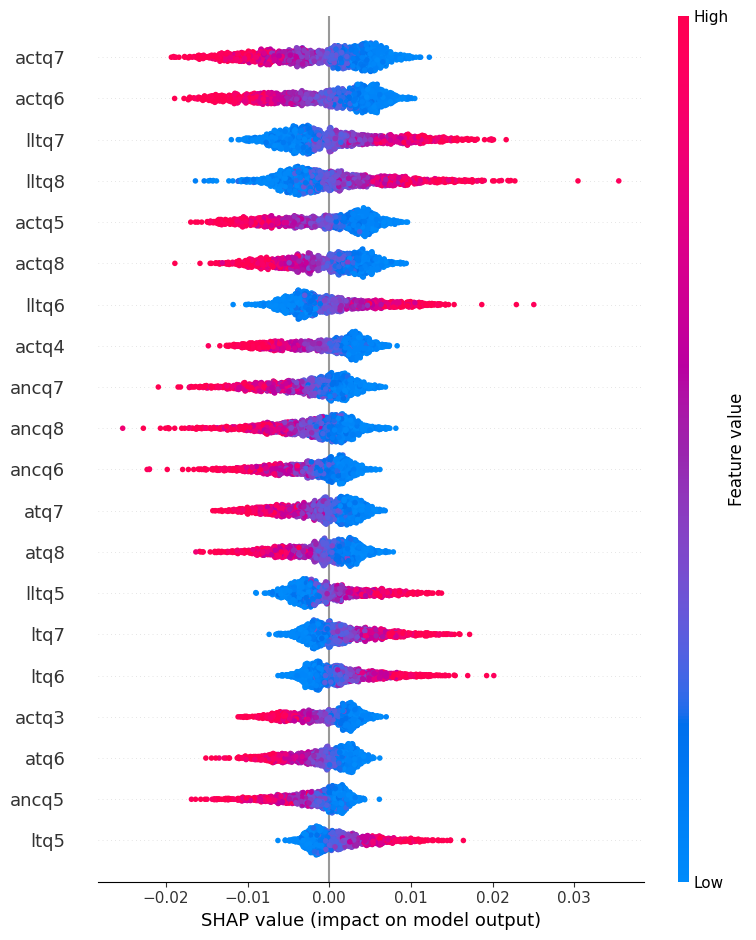

In [15]:
import shap

model.eval()

all_shap_values = []
all_data_to_explain = []

for batch in valid_loader:
    data_batch = batch[0].to(device)
    
    explainer = shap.DeepExplainer(model, data_batch)
    shap_values_batch = explainer.shap_values(data_batch, check_additivity=False)
    
    shap_values_reshaped_batch = np.reshape(shap_values_batch, (shap_values_batch.shape[0], -1))
    all_shap_values.append(shap_values_reshaped_batch)
    
    data_to_explain_reshaped_batch = data_batch.view(data_batch.size(0), -1).cpu().numpy()
    all_data_to_explain.append(data_to_explain_reshaped_batch)

all_shap_values = np.vstack(all_shap_values)
all_data_to_explain = np.vstack(all_data_to_explain)

shap.summary_plot(all_shap_values, all_data_to_explain, feature_names=extended_feature_names)


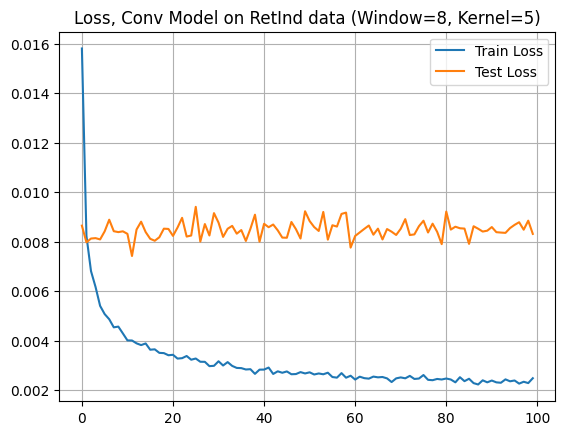

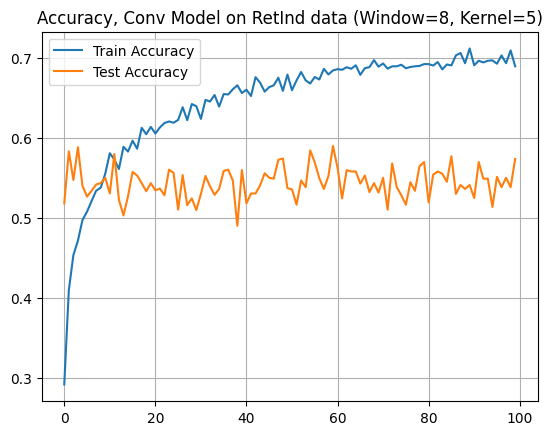

In [17]:
utils.plot_graph(*best_history, identifier="Conv Model on RetInd data (Window=8, Kernel=5)")

In [18]:
train_loss, train_accuracy, valid_loss, valid_accuracy = best_history
print(train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1])

0.002479909695011737 0.6890932558889965 0.008315981875253097 0.5734304932735426


# -----------------

In [ ]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=283 len(test_dict)=59
Ret


In [ ]:
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
print(f"{input_size=}")

input_size=38


Vaild Epoch 199: 100%|██████████| 200/200 [05:10<00:00,  1.55s/it, Loss: 0.011]


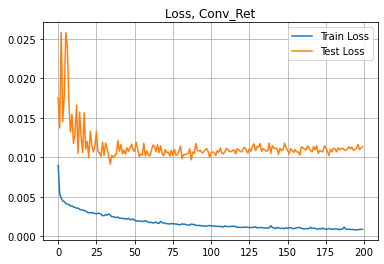

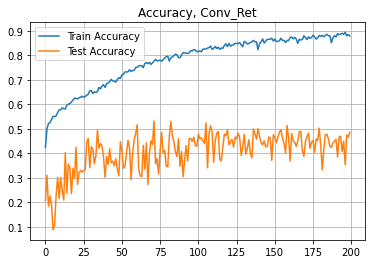

In [ ]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader,
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Infer

In [ ]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from '/Users/Ryo/Desktop/UCLA/PNC_Capstone/Inferencer.py'>

In [ ]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

test_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, accuracy, diff_counter = inferencer.infer()

In [ ]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([5., 5., 4., 4., 4., 4., 4., 4., 3., 4.])
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])


In [ ]:
print(diff_counter)

Counter({0.0: 666, 1.0: 549, 2.0: 109, 5.0: 25, 4.0: 8, 3.0: 7, 6.0: 5})


In [ ]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=1369


In [ ]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.4864864864864865,
 0.887509130752374,
 0.9671292914536158,
 0.9722425127830533,
 0.9780861943024105]

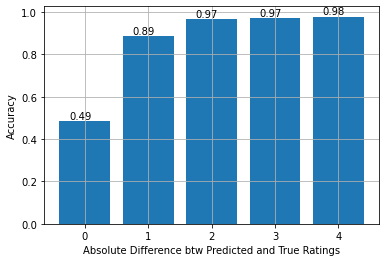

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()